# Validus Fund IV Hedging Case Study
Validus Fund IV is a Private Equity Fund (USD Fund) and invests in several kinds of Assets across Europe and North America, it is thus exposed to Foreign Exchange risk. The fund managers are particularly interested to hedge their risk by using Knock-In Options.
You are being given market data (please find excel file attached) and are asked to perform the following:

#### a) Please create some hypothetical fund model including USD, EUR and GBP investments.
#### b) Calculate the IRR (internal rate of return) at risk of the fund model you created by using Forex Monte Carlo simulation. You can assume the returns of investments are static. Please use any model you think is suitable for this task.

# Assumptions Ahead
1. Assume there is 100 million USD of captial for FX investment. Here the volatility parity of FX rate is applied to decide weights for foreign investment of assets in EUR and GBP.
2. According to the interest of the fund manager, a barrier knock-in swaption used for hedging of FX exposure is priced here by FX Monte Carlo simulation, with IRR at risk be a metric of risk return. Here mean value of FX rate is set to be the threshold of barrier swaption.

In [1]:
#import packages
import numpy as np
import math
from math import sqrt, exp
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.stats as st
import statsmodels as sm
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#data reading with format cleaning
df = pd.read_excel('market_data_2019.04.10.xlsx', header=4, parse_dates=['BBG Ticker'], sheet_name = 'Data_Values',index_col=1)
df = df.iloc[[1]+list(range(3,5030)),1:]
df.head()

In [ ]:
#get FX rate and calculate the volatilities
fx = df.iloc[1:,0:2]
fx.head()

In [ ]:
fx_vol = pd.DataFrame(fx.std())
fx.std()

In [ ]:
#Perform volatility parity on investment weights
weight = pd.DataFrame(np.reciprocal(fx_vol.values)/np.reciprocal(fx_vol.values).sum())
exposure = pd.DataFrame(weight*100)
exposure.columns = ['Million USD']
exposure.index = fx_vol.index
exposure

Here we would decide to invest approximately 54.4 million USD in EUR currency exposure and 45.6 million USD in GBP currency exposure. Then, the knock-in swaptions are used to hedge the FX risk.

# Introduction of Knock-in Swaption
The knock-in option is a type of barrier option, with two cases of *down-and-in* and *up-and-in*. Here the option applied is the cross currency swaption, where the right of the buyer to exercise the swaption appears on certain barrier.

Here Validus Fund is in USD so we are expecting to convert the foreign assets into USD in the furture. In this case if foreign currencies depreciate in the future, i.e. if the FX rate decreases, the fund would face fx risk. Therefore, a *down-and-in* receiver swaption is a suggested choice for the fund manager.

A knock-in cross currency swaption expires worthless unless the fx rate reaches the barrier before expiry. If the cross currency rate hits the bottom line at some time before expiry, then the barrier swaption becomes a vanilla swaption. Here we assume an European swaption and would apply BSM model for pricing.

### Setting the threshold for the bottom line FX rate
Here we make the assumption to take the mean value of FX rate as a bottom-line threshold for the Swaptions

In [6]:
fx_thre = fx.mean()
fx_thre

EURUSD BGN Curncy    1.213244
GBPUSD BGN Curncy    1.599435
dtype: float64

### Distribution fitting of FX rates
The usage of distribution fitting of EURUSD and GBPUSD currency is to set random numbers of FX rate in Monte Carlo Simulation based on the same distribution of historical data.

#### Distribution Fitting with Sum of Square Error (SSE) 

In [7]:
# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end 
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=len(fx)):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf


In [8]:
# Load historical FX data from statsmodels datasets
data_eur = pd.Series(fx.iloc[:,0])
data_gbp = pd.Series(fx.iloc[:,1])

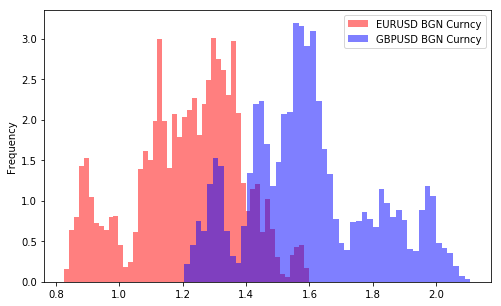

In [9]:
# Plot histograms of EUR and GBP FX rate distribution for comparison
ax_eur = data_eur.plot(figsize=(8,5), kind='hist', bins=50, normed=True, alpha=0.5, color = 'r',legend=True)
ax_gbp = data_gbp.plot(figsize=(8,5), kind='hist', bins=50, normed=True, alpha=0.5, color = 'b',legend=True)


In [10]:
# Save plot limits
dataYLim_eur = ax_eur.get_ylim()
dataYLim_gbp = ax_gbp.get_ylim()


In [11]:
# Find best fit distribution for EURUSD
best_fit_name_eur, best_fit_params_eur = best_fit_distribution(data_eur, 200, ax_eur)
best_fit_name_eur

'norm'

In [12]:
# Find best fit distribution for GBPUSD
best_fit_name_gbp, best_fit_params_gbp = best_fit_distribution(data_gbp, 200, ax_gbp)
best_fit_name_gbp

'norm'

#### Here we can see the best fit distribution for both EURUSD and GBPUSD is *normal distribution*.

In [13]:
# Make PDF with best params 
best_dist_eur = getattr(st, best_fit_name_eur)
best_dist_gbp = getattr(st, best_fit_name_gbp)
pdf_eur = make_pdf(best_dist_eur, best_fit_params_eur)
pdf_gbp = make_pdf(best_dist_gbp, best_fit_params_gbp)


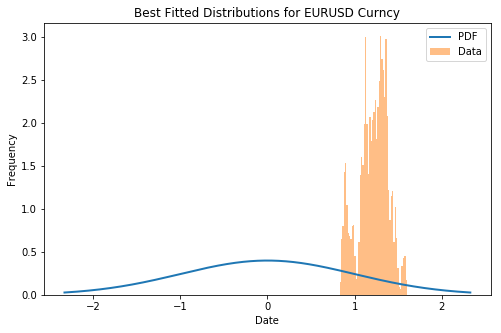

In [14]:
# Display the best fitted distribution for EURUSD 
ax_eur = pdf_eur.plot(figsize=(8,5),lw=2, label='PDF', legend=True)
ax_eur.set_title('Best Fitted Distributions for EURUSD Curncy')
ax_eur.set_xlabel('Date')
ax_eur.set_ylabel('Frequency')
data_eur.plot(kind='hist', bins=50, normed=True, alpha=0.5, label='Data', legend=True, ax=ax_eur)


In [15]:
# Get summary statistics for the fitted distribution of EURUSD Curncy
stats_eur = pd.DataFrame(pdf_eur).describe()
stats_eur

,0
count,5027.000000
mean,0.210594
std,0.127323
min,0.026652
25%,0.087036
50%,0.202713
75%,0.336824
max,0.398942


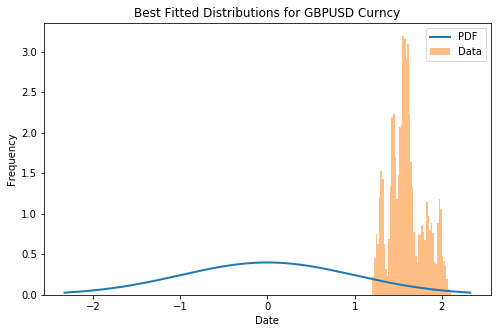

In [16]:
# Display the best fitted distribution for GBPUSD
ax_gbp = pdf_gbp.plot(figsize=(8,5),lw=2, label='PDF', legend=True)
ax_gbp.set_title('Best Fitted Distributions for GBPUSD Curncy')
ax_gbp.set_xlabel('Date')
ax_gbp.set_ylabel('Frequency')
data_gbp.plot(kind='hist', bins=50, normed=True, alpha=0.5, label='Data', legend=True, ax=ax_gbp)

In [17]:
# Get summary statistics for the fitted distribution of GBPUSD Curncy
stats_gbp = pd.DataFrame(pdf_gbp).describe()
stats_gbp

,0
count,5027.000000
mean,0.210594
std,0.127323
min,0.026652
25%,0.087036
50%,0.202713
75%,0.336824
max,0.398942


# Pricing Model Designing

Here a down-and-in receiver swaption is a reasonable hedging instrument to use. Since we want to receive fixed and pay floating rates when FX forward rate is below a bottom line.

## Notations



$F$ = forward exchange rate of underlying swap
<br>
$X$ = strike rate of swaption
<br>
$r$ = risk-free interest rate
<br>
$T$ = time to expiration in years
<br>
$t_{1}$ = tenor of swap in years
<br>
$\sigma$ = volatility of the forward-starting swap rate
<br>
$m$ = compoundings per year in swap rate
<br>
Let $p$ denotes the price of a receiver swaption
<br>
$p = [\frac{1 - (1 + F/m)^{-t_{1}\times m}}{F}] \cdot e^{-rT}[XN(-d_{2}) - FN(-d_{1}) ]$
<br>
where,
<br>
$d_{1} = [\frac{ln(F/X) + (\sigma ^2 / 2)T}{\sigma\sqrt{T}}]$ and $d_{2} = d_{1} - \sigma\sqrt{T}$


In [18]:
#Relevent data for swaption pricing
df_eur_forward = df.iloc[:,3:31]
df_gbp_forward = df.iloc[:,31:59]
df_eur_impvol = df.iloc[:,78:96]
df_gbp_impvol = df.iloc[:,96:114]
df_eur_yield = df.iloc[:,132:147]
df_gbp_yield = df.iloc[:,147:162]

In [19]:
def receiver_swaption(F, X, r, T, t1, sigma, m):
    """pricing a receiver swaption by applying BSM model"""
    d1 = (math.log(F/X) + math.pow(sigma,2)/2 * T)/ sigma*sqrt(T)
    d2 = d1 - sigma * sqrt(T)
    p = (1-math.pow((1+F/m),(-t1*m)))/F * math.pow(exp(1),(-r*T))*(X*norm.cdf(-d2) - F*norm.cdf(-d1))
    return p   

#### Test function
Consider a 2-year receiver swaption on a 4-year swap with semi-annual compounding. The forward swap rate of 7% starts 2 years from now and ends 6 years from now. The strike is 7.5%; the risk-free interest rate is 6%; the volatility of the forward starting swap rate is 20% p.a.

In [20]:
p_test = receiver_swaption(0.07, 0.075, 0.06, 2, 4, 0.2, 2)
p_test

0.03308262379151632

## My ideas here

#### Assume first without considering the barrier, assume we take a 2 year receiver swaption on a 4 year swap with monthly compounding

Here we have got the data for  <br>
$F$: forward exchange rate at different maturities;<br> 
$X$: the swap rate at the start of swap contract to make the initial value zero;<br> 
$r$: set 10 yr yield rate as the risk-free rate; <br>
$T$ = 2; <br> 
$t_{1}$ = 4; <br> 
$\sigma$: apply data of 2-year implied volatility, transfer to annual volatility;<br> 
$m$ = 12 <br>

Therefore, we can get the prices of the receiver swaption without barrier using the BSM formula.


Taking the consideration of the barrier, here we set the mean value of FX rate as the bottom-line barrier, which are 1.249300 for EURUSD and 1.047466 for GBPUSD.

We first generate random rates with the same distribution as the historical data that either meet the barrier or not. Then perform the FX Monte Carlo Simulation on swaption pricing. In the case when FX rate doesn't reach the bottom, the swaption value would be zero. Otherwise it would be calculated in the normal way as stated before.

In [21]:
def fx_generator (mu, sigma, N):
    """Generate random sample based on historical distribution of FX rates"""
    s = np.random.normal(mu, sigma, N)
    s[s < 0] = 0
    return s

In [22]:
#Generate random sample of EURUSD
mu_eur, sigma_eur, N = 1.249300, 0.755314, 1000 
s_eur = pd.DataFrame(fx_generator(mu_eur, sigma_eur, N))
s_eur.head()

,0
0,1.032164
1,1.484565
2,1.441342
3,0.055075
4,1.622023


In [26]:
#Generate random sample of GBPUSD
mu_gbp, sigma_gbp = 1.047466, 0.633287
s_gbp = pd.DataFrame(fx_generator(mu_gbp, sigma_gbp, N))
s_gbp.head()

,0
0,1.952649
1,1.047684
2,1.242938
3,1.911868
4,1.603521


The next step would be to put the random number generated inside a for loop for several times to get the expected pricing for the down-and-in swaption. 

In [30]:
#pricing of GBPUSD
#s = pd.DataFrame(index=range(1000),columns=range(1000))
#p_gbp = pd.DataFrame(index=range(1000),columns=range(1000))
#for i in range(1000):
    #s.iloc[i,:] = s_gbp
    #if s.iloc[i,j] < mu_gbp:
        #p_gbp.iloc[i,j] = receiver_swaption(F, X, r, T, t1, sigma, m)
    #else:
        #p_gbp.iloc[i,j] = 0
#p_gbp = p_gbp.mean() 

## IRR at risk

The rational of IRR is the required rate of return when the discounted value of costs equal to the discounted value of profits. So when performing the FX Monte Carlo Simulation we would get each random process a rate of IRR. My idea is to summarize the overall IRR and set a mean value of IRR to be the IRR at risk.

*The approximate time I spent on this case study is 1.5 days.*